In [1]:
%matplotlib inline


# Getting started tutorial

In this introductory example, you will see how to use the :code:`spikeinterface` to perform a full electrophysiology analysis.
We will first create some simulated data, and we will then perform some pre-processing, run a couple of spike sorting
algorithms, inspect and validate the results, export to Phy, and compare spike sorters.


In [2]:
import matplotlib.pyplot as plt

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [3]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [4]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [5]:
import spikeinterface.full as si

First, let's download a simulated dataset from the
'https://gin.g-node.org/NeuralEnsemble/ephy_testing_data' repo

Then we can open it. Note that `MEArec <https://mearec.readthedocs.io>`_ simulated file
contains both "recording" and a "sorting" object.



In [6]:
local_path = si.download_dataset(remote_path='mearec/mearec_test_10s.h5')
recording, sorting_true = se.read_mearec(local_path)
print(recording)
print(sorting_true)

MEArecRecordingExtractor: 32 channels - 1 segments - 32.0kHz - 10.000s
  file_path: /home/riwata/spikeinterface_datasets/ephy_testing_data/mearec/mearec_test_10s.h5
MEArecSortingExtractor: 10 units - 1 segments - 32.0kHz
  file_path: /home/riwata/spikeinterface_datasets/ephy_testing_data/mearec/mearec_test_10s.h5


:code:`recording` is a :code:`RecordingExtractor` object, which extracts information about channel ids, channel locations
(if present), the sampling frequency of the recording, and the extracellular  traces. :code:`sorting_true` is a
:code:`SortingExtractor` object, which contains information about spike-sorting related information,  including unit ids,
spike trains, etc. Since the data are simulated, :code:`sorting_true` has ground-truth information of the spiking
activity of each unit.

Let's use the :code:`widgets` module to visualize the traces and the raster plots.



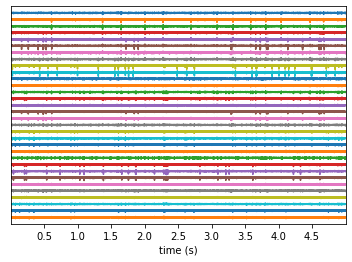

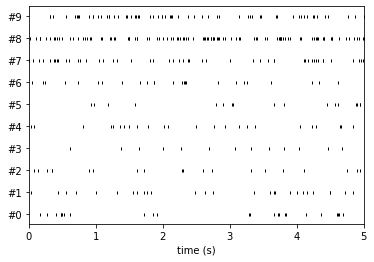

In [7]:
w_ts = sw.plot_timeseries(recording, time_range=(0, 5))
w_rs = sw.plot_rasters(sorting_true, time_range=(0, 5))

This is how you retrieve info from a :code:`RecordingExtractor`...



In [8]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_seg = recording.get_num_segments()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)

Channel ids: ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32']
Sampling frequency: 32000.0
Number of channels: 32
Number of segments: 1


...and a :code:`SortingExtractor`



In [9]:
num_seg = recording.get_num_segments()
unit_ids = sorting_true.get_unit_ids()
spike_train = sorting_true.get_unit_spike_train(unit_id=unit_ids[0])

print('Number of segments:', num_seg)
print('Unit ids:', unit_ids)
print('Spike train of first unit:', spike_train)

Number of segments: 1
Unit ids: ['#0' '#1' '#2' '#3' '#4' '#5' '#6' '#7' '#8' '#9']
Spike train of first unit: [  5197   8413  13124  15420  15497  15668  16929  19607  55107  59060
  60958 105193 105569 117082 119243 119326 122293 122877 132413 139498
 147402 147682 148271 149857 165454 170569 174319 176237 183598 192278
 201535 217193 219715 221226 222967 223897 225338 243206 243775 248754
 253184 253308 265132 266197 266662 283149 284716 287592 304025 305286
 310438 310775 318460]


:code:`spikeinterface` internally uses the :code:`probeinterface`
to handle Probe and ProbeGroup.
 So any probe in the probeinterface collections can be download
and set to a Recording object.
In this case, the MEArec dataset already handles a Probe and we don't need to set it.



Probe - 32ch - 1shanks


(<matplotlib.collections.PolyCollection at 0x7f435455c9d0>,
 <matplotlib.collections.PolyCollection at 0x7f43e36c93d0>)

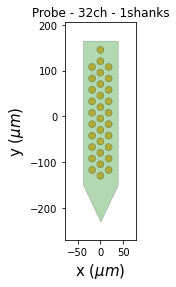

In [10]:
probe = recording.get_probe()
print(probe)

from probeinterface.plotting import plot_probe

plot_probe(probe)

Using the :code:`toolkit`, you can perform preprocessing on the recordings.
Each pre-processing function also returns a :code:`RecordingExtractor`,
which makes it easy to build pipelines. Here, we filter the recording and
apply common median reference (CMR).
All theses preprocessing steps are "lazy". The computation is done on demand when we call
`recording.get_traces(...)` or when we save the object to disk.



In [11]:
recording_cmr = recording
recording_f = st.bandpass_filter(recording, freq_min=300, freq_max=6000)
print(recording_f)
recording_cmr = st.common_reference(recording_f, reference='global', operator='median')
print(recording_cmr)

# this computes and saves the recording after applying the preprocessing chain
recording_preprocessed = recording_cmr.save(format='binary')
print(recording_preprocessed)

BandpassFilterRecording: 32 channels - 1 segments - 32.0kHz - 10.000s
CommonReferenceRecording: 32 channels - 1 segments - 32.0kHz - 10.000s
Use cache_folder=/tmp/spikeinterface_cache/tmpsyb1vli3/2OAKWUMY
write_binary_recording with n_jobs 1  chunk_size None
BinaryRecordingExtractor: 32 channels - 1 segments - 32.0kHz - 10.000s
  file_paths: ['/tmp/spikeinterface_cache/tmpsyb1vli3/2OAKWUMY/traces_cached_seg0.raw']


Now you are ready to spike sort using the :code:`sorters` module!
Let's first check which sorters are implemented and which are installed



In [12]:
print('Available sorters', ss.available_sorters())
print('Installed sorters', ss.installed_sorters())

Available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'klusta', 'mountainsort4', 'pykilosort', 'spykingcircus', 'tridesclous', 'waveclus', 'yass']


/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/spikeextractors/extractors/mearecextractors/mearecextractors.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if StrictVersion(mr.__version__) >= '1.5.0':


Installed sorters ['mountainsort4', 'tridesclous']


The :code:`ss.installed_sorters()` will list the sorters installed in the machine.
We can see we have mountainsort4 and Tridesclous installed.
Spike sorters come with a set of parameters that users can change.
The available parameters are dictionaries and can be accessed with:



In [13]:
print(ss.get_default_params('mountainsort4'))

{'detect_sign': -1, 'adjacency_radius': -1, 'freq_min': 300, 'freq_max': 6000, 'filter': True, 'whiten': True, 'num_workers': 1, 'clip_size': 50, 'detect_threshold': 3, 'detect_interval': 10}


Let's run mountainsort4 and change one of the parameter, say, the detect_threshold:



In [14]:
sorting_HS = ss.run_mountainsort4(recording=recording_preprocessed, detect_threshold=4)
print(sorting_HS)

Mountainsort4 use the OLD spikeextractors mapped with RecordingExtractorOldAPI


/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/neo/io/nixio.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_NIX_VER = Version("1.5.0")
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/neo/io/neomatlabio.py:30: DeprecationWarning: distutils Version classes are depr

NpzSortingExtractor: 20 units - 1 segments - 32.0kHz
  file_path: /home/riwata/Projects/spike_sorting/results/2022_03_09_mountain_sort_test/mountainsort4_output/firings.npz


Alternatively we can pass full dictionary containing the parameters:



In [15]:
other_params = ss.get_default_params('mountainsort4')
other_params['detect_threshold'] = 5

# parameters set by params dictionary
sorting_HS_2 = ss.run_mountainsort4(recording=recording_preprocessed, output_folder="redringspikes_output2",
                                    **other_params)
print(sorting_HS_2)

Mountainsort4 use the OLD spikeextractors mapped with RecordingExtractorOldAPI


/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/neo/io/nixio.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_NIX_VER = Version("1.5.0")
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/neo/io/neomatlabio.py:30: DeprecationWarning: distutils Version classes are depr

NpzSortingExtractor: 14 units - 1 segments - 32.0kHz
  file_path: /home/riwata/Projects/spike_sorting/results/2022_03_09_mountain_sort_test/redringspikes_output2/firings.npz


Let's run tridesclous as well, with default parameters:



In [16]:
sorting_TDC = ss.run_tridesclous(recording=recording_preprocessed)

/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/tridesclous/dataio.py:175: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  v1 = distutils.version.LooseVersion(tridesclous_version).version
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/tridesclous/dataio.py:176: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  v2 = distutils.version.LooseVersion(self.info['tridesclous_version']).version
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/setuptools

The :code:`sorting_HS` and :code:`sorting_TDC` are :code:`SortingExtractor`
objects. We can print the units found using:



In [17]:
print('Units found by mountainsort4:', sorting_HS.get_unit_ids())
print('Units found by tridesclous:', sorting_TDC.get_unit_ids())

Units found by mountainsort4: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Units found by tridesclous: [0 1 2 3 4 5 6 7 8 9]


:code:`spikeinterface` provides a efficient way to extractor waveform snippets from paired recording/sorting objects.
The :code:`WaveformExtractor` class samples some spikes (:code:`max_spikes_per_unit=500`) for each cluster and stores
them on disk. These waveforms per cluster are helpful to compute the average waveform, or "template", for each unit
and then to compute, for example, quality metrics.



In [18]:
we_TDC = si.WaveformExtractor.create(recording_preprocessed, sorting_TDC, 'waveforms', remove_if_exists=True)
we_TDC.set_params(ms_before=3., ms_after=4., max_spikes_per_unit=500)
we_TDC.run_extract_waveforms(n_jobs=-1, chunk_size=30000)
print(we_TDC)

unit_id0 = sorting_TDC.unit_ids[0]
wavefroms = we_TDC.get_waveforms(unit_id0)
print(wavefroms.shape)

template = we_TDC.get_template(unit_id0)
print(template.shape)

WaveformExtractor: 32 channels - 10 units - 1 segments
  before:96 after128 n_per_units: 500
(30, 224, 32)
(224, 32)


Once we have the  `WaveformExtractor` object
we can post-process, validate, and curate the results. With
the :code:`toolkit.postprocessing` submodule, one can, for example,
get waveforms, templates, maximum channels, PCA scores, or export the data
to Phy. `Phy <https://github.com/cortex-lab/phy>`_ is a GUI for manual
curation of the spike sorting output. To export to phy you can run:



In [19]:
from spikeinterface.exporters import export_to_phy

export_to_phy(we_TDC, './phy_folder_for_TDC',
              compute_pc_features=False, compute_amplitudes=True)

write_binary_recording with n_jobs 1  chunk_size None


/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/tridesclous/dataio.py:175: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  v1 = distutils.version.LooseVersion(tridesclous_version).version
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/tridesclous/dataio.py:176: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  v2 = distutils.version.LooseVersion(self.info['tridesclous_version']).version


Run:
phy template-gui  /home/riwata/Projects/spike_sorting/results/2022_03_09_mountain_sort_test/phy_folder_for_TDC/params.py


Then you can run the template-gui with: :code:`phy template-gui phy/params.py`
and manually curate the results.



Quality metrics for the spike sorting output are very important to asses the spike sorting performance.
The :code:`spikeinterface.toolkit.qualitymetrics` module implements several quality metrics
to assess the goodness of sorted units. Among those, for example,
are signal-to-noise ratio, ISI violation ratio, isolation distance, and many more.
Theses metrics are built on top of WaveformExtractor class and return a dictionary with the unit ids as keys:



In [21]:
st.compute_isi_violations(we_TDC, isi_threshold_ms=1.5)

isi_violaion(isi_violations_rate={0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}, isi_violations_count={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0})

In [22]:
snrs = st.compute_snrs(we_TDC)
print(snrs)
isi_violations_rate, isi_violations_count = st.compute_isi_violations(we_TDC, isi_threshold_ms=1.5)
print(isi_violations_rate)
print(isi_violations_count)

{0: 27.25771, 1: 24.215496, 2: 24.246685, 3: 27.081985, 4: 13.247957, 5: 9.574343, 6: 8.125438, 7: 8.689331, 8: 11.160513, 9: 8.442262}
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}


All theses quality metrics can be computed in one shot and returned as
a :code:`pandas.Dataframe`



In [23]:
metrics = st.compute_quality_metrics(we_TDC, metric_names=['snr', 'isi_violation', 'amplitude_cutoff'])
print(metrics)

         snr  isi_violations_rate  isi_violations_count  amplitude_cutoff
0  27.257710                  0.0                     0          0.008626
1  24.215496                  0.0                     0          0.005074
2  24.246685                  0.0                     0          0.144832
3  27.081985                  0.0                     0          0.005176
4  13.247957                  0.0                     0          0.006018
5   9.574343                  0.0                     0          0.007188
6   8.125438                  0.0                     0          0.005391
7   8.689331                  0.0                     0          0.089688
8  11.160513                  0.0                     0          0.002006
9   8.442262                  0.0                     0          0.252680


Quality metrics can be also used to automatically curate the spike sorting
output. For example, you can select sorted units with a SNR above a
certain threshold:



In [24]:
keep_mask = (metrics['snr'] > 7.5) & (metrics['isi_violations_rate'] < 0.01)
print(keep_mask)

keep_unit_ids = keep_mask[keep_mask].index.values
print(keep_unit_ids)

curated_sorting = sorting_TDC.select_units(keep_unit_ids)
print(curated_sorting)

0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
9    True
dtype: bool
[0 1 2 3 4 5 6 7 8 9]
UnitsSelectionSorting: 10 units - 1 segments - 32.0kHz


The final part of this tutorial deals with comparing spike sorting outputs.
We can either (1) compare the spike sorting results with the ground-truth
sorting :code:`sorting_true`, (2) compare the output of two (mountainsort4
and Tridesclous), or (3) compare the output of multiple sorters:



In [25]:
comp_gt_TDC = sc.compare_sorter_to_ground_truth(gt_sorting=sorting_true, tested_sorting=sorting_TDC)
comp_TDC_HS = sc.compare_two_sorters(sorting1=sorting_TDC, sorting2=sorting_HS)
comp_multi = sc.compare_multiple_sorters(sorting_list=[sorting_TDC, sorting_HS],
                                         name_list=['tdc', 'hs'])

When comparing with a ground-truth sorting extractor (1), you can get the sorting performance and plot a confusion
matrix



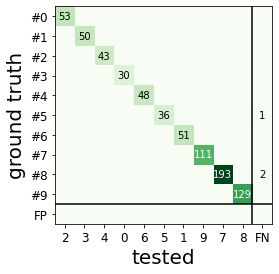

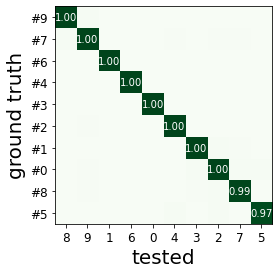

In [26]:
comp_gt_TDC.get_performance()
w_conf = sw.plot_confusion_matrix(comp_gt_TDC)
w_agr = sw.plot_agreement_matrix(comp_gt_TDC)

When comparing two sorters (2), we can see the matching of units between sorters.
Units which are not matched has -1 as unit id:



In [27]:
comp_TDC_HS.hungarian_match_12

0     2
1    18
2     4
3     7
4    13
5    -1
6    12
7    16
8     6
9    15
dtype: int64

or the reverse:



In [28]:
comp_TDC_HS.hungarian_match_21

1    -1
2     0
3    -1
4     2
5    -1
6     8
7     3
8    -1
9    -1
10   -1
11   -1
12    6
13    4
14   -1
15    9
16    7
17   -1
18    1
19   -1
20   -1
dtype: int64

When comparing multiple sorters (3), you can extract a :code:`SortingExtractor` object with units in agreement
between sorters. You can also plot a graph showing how the units are matched between the sorters.



Units in agreement between Klusta and Mountainsort4: [0 1 2 3 4 6 7 8 9]


/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:402: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(alpha, collections.Iterable):
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/riwata/Pro

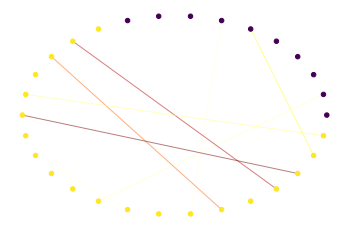

In [29]:
sorting_agreement = comp_multi.get_agreement_sorting(minimum_agreement_count=2)

print('Units in agreement between Klusta and Mountainsort4:', sorting_agreement.get_unit_ids())

w_multi = sw.plot_multicomp_graph(comp_multi)

plt.show()